In [27]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# helper functions
def convert_dtype(df):
    for col in set(df.columns) - set(df.describe().columns):
        df[col] = df[col].astype('category')
    print(df.info())

def remove_na(df):
    for i,j in zip(df.columns,(df.values.astype(str) == '?').sum(axis=0)):
        if j > 0:
            print(f'{str(i)}: {str(j)} missing reconds.')
            df[i].replace('?', np.nan, inplace=True)
    print(f'Before dropping NA values, the DataFrame has {len(df.index)} records.')
    df.dropna(inplace=True) 
    print(f'After dropping NA values, the DataFrame has {len(df.index)} records.')
    
def to_one_hot(df):
    # convert categorical variables to one-hot encodings
    df_cat_oh = pd.get_dummies(df.select_dtypes('category'))
    df_non_cat = df.select_dtypes(exclude = 'category')
    
    df_oh = pd.concat([df_non_cat, df_cat_oh], axis=1, join='inner')
    return df_oh

# removes one hot encoded columns
def preprocess_dataset(df):
    exclude_columns = ['race_', 'gender_']
    cols = []
    for exclude in exclude_columns:
        cols += [c for c in df.columns if exclude in c.lower()]
    return df.drop(cols, axis=1)

def evaluate_model(actual, predictions):
    confusion = pd.crosstab(actual, predictions, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc['>50K','>50K']
    TN = confusion.loc['<=50K','<=50K']
    FP = confusion.loc['<=50K','>50K']
    FN = confusion.loc['>50K','<=50K']

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    pos_labelled = (TP + FP) / (TP+FN+FP+TN)
    neg_labelled = 1 - pos_labelled
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    out['pos_parity'] = pos_labelled
    out['neg_parity'] = neg_labelled
    
    out['TP'] = TP
    out['TN'] = TN
    out['FP'] = FP
    out['FN'] = FN
    return out

def evaluate_group(df, attr, preprocess=True):
    results = []
    # i.e. if we want just a binary comparison
    if len(attr.split('_')) > 1:
        results.append(evaluate_model(df[df[attr] == 1]['income'],
                                    df[df[attr] == 1]['predicted_income']))
        results.append(evaluate_model(df[df[attr] == 0]['income'],
                                    df[df[attr] == 0]['predicted_income']))
        return pd.DataFrame(results, index=[attr, f'not_{attr}'])
    else:
        groups = [c for c in df.columns if attr in c.lower()]
        for group in groups:
            result = evaluate_model(df[df[group] == 1]['income'],
                                    df[df[group] == 1]['predicted_income'])
            results.append(result)
        return pd.DataFrame(results, index=groups)

def get_posneg(df):
    pos = df[df['income']=='>50K']['income'].count()
    neg = df[df['income']=='<=50K']['income'].count()
    assert((pos+neg) == df['income'].count())
    #print(f'pos : {pos}, neg: {neg}')
    return  pos / (pos + neg)

def resample_group(df, group):
    neg, pos = df['income'].value_counts()
    pos = pos / (pos+neg)
    neg = 1 - pos
    
    num_samples = df[df[group]==1]['income'].count()

    group_neg, group_pos = df[df[group]==1]['income'].value_counts()
    #print(group_pos, group_neg)
    
    if (group_pos/(group_pos+group_neg)) > pos:
        oversample_pos = False
        oversample_neg = True
    else:
        oversample_pos = True
        oversample_neg = False
    
    neg_sample_size = math.floor(neg*num_samples)
    neg_df = df[(df[group]==1) & (df['income']=='<=50K')] \
                .sample(neg_sample_size, replace=oversample_neg)
    pos_df = df[(df[group]==1) & (df['income']=='>50K')] \
                .sample(num_samples-neg_sample_size, replace=oversample_pos)

    res_df = pd.concat([neg_df, pos_df], axis=0) 
    #print(res_df['income'].value_counts())
    count = res_df['income'].count()
    #print(f'Sample size: {count}')
    return res_df

In [2]:
# read data
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'educational-num','marital-status', 'occupation', 'relationship', 
           'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 
           'native-country','income']

train = pd.read_csv('../data/adult_data.txt', sep=',\s', header=None, names=columns)
test = pd.read_csv('../data/adult_test.txt', sep=',\s', header=None, names=columns)

test.drop(index=0, inplace=True)
test['income'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')

G:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys
G:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
# overall pos-neg ratio
print(get_posneg(train))
print(get_posneg(test))

# race pos-neg ratio
print('--------Gender----------\n')
print('--------Training Data----------')
x = get_posneg(train[train['gender'] == 'Female'])
print(f'Female: {x}')
x = get_posneg(train[train['gender'] == 'Male'])
print(f'Male: {x}')
print('\n--------Test Data----------')
x = get_posneg(test[test['gender'] == 'Female'])
print(f'Female: {x}')
x = get_posneg(test[test['gender'] == 'Male'])
print(f'Male: {x}')

# gender pos-neg ratio
print('--------Race----------\n')
print('--------Training Data----------')
x = get_posneg(train[train['race'] == 'White'])
print(f'White: {x}')
x = get_posneg(train[train['race'] != 'White'])
print(f'Not White: {x}')
print('\n--------Test Data----------')
x = get_posneg(test[test['race'] == 'White'])
print(f'White: {x}')
x = get_posneg(test[test['race'] != 'White'])
print(f'Not White: {x}')

In [10]:
for i, row in train.iterrows():
    if row['race'] == 'White':
        row['real_race'] = 'White'
        train.loc[i, 'real_race'] = 'White'
    else:
        row['real_race'] = 'Non-White'
        train.loc[i, 'real_race'] = 'Non-White'

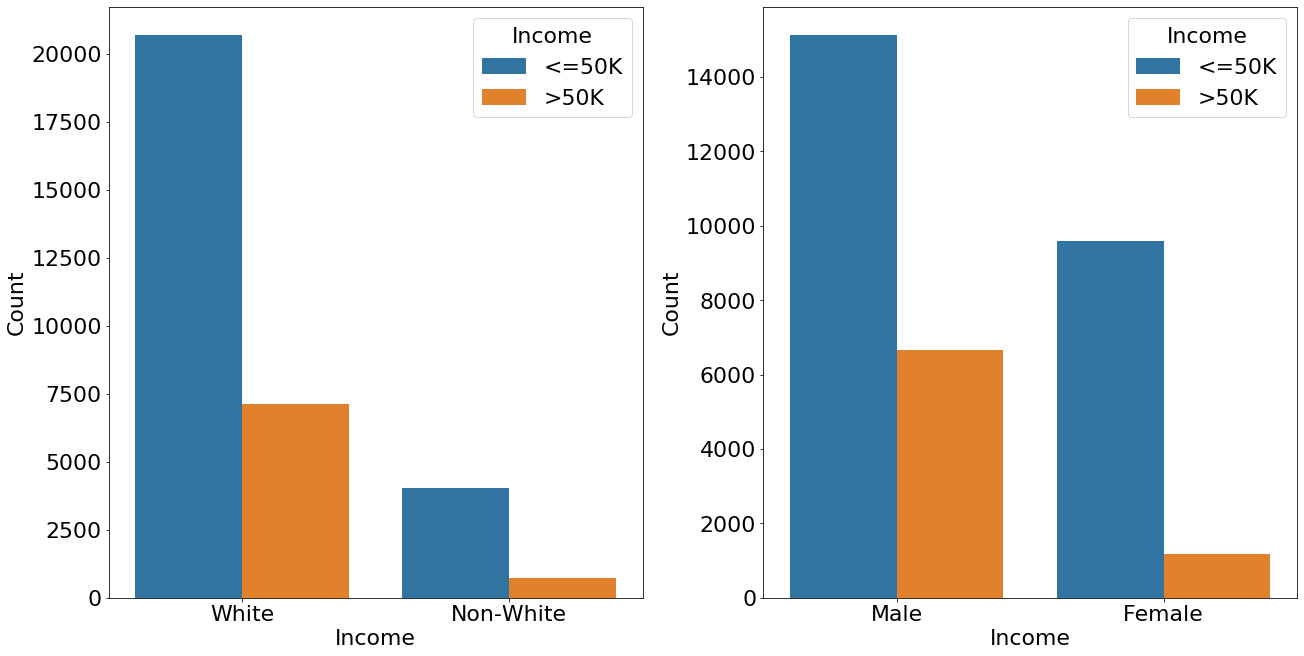

In [12]:
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(1, 2, figsize=(18,9), constrained_layout=True)

# income stats for race
sns.countplot(x=train['real_race'], hue=train['income'], ax=axs[0])
axs[0].set_xlabel('Income')
axs[0].set_ylabel('Count')
axs[0].legend(title='Income')

# income stats for gender
sns.countplot(x=train['gender'], hue=train['income'], ax=axs[1])
axs[1].set_xlabel('Income')
axs[1].set_ylabel('Count')
axs[1].legend(title='Income')

plt.savefig('race-gender-distribution.png')
train.drop(columns=['real_race'], inplace=True)

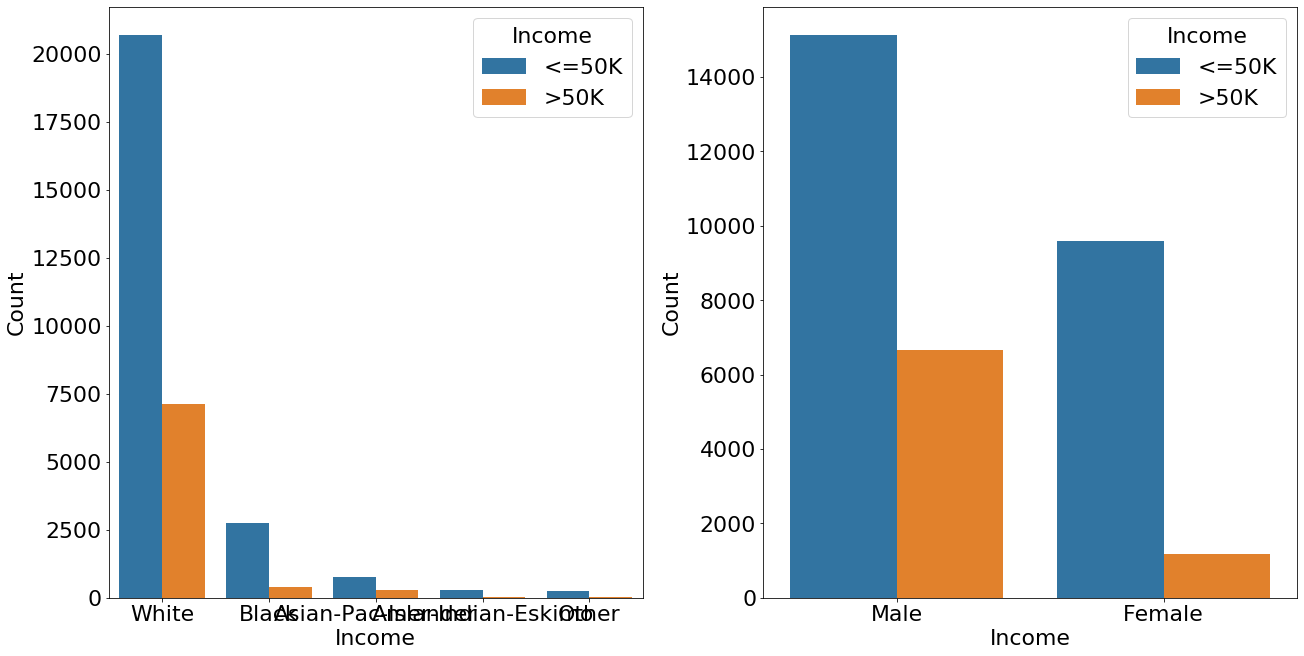

In [4]:
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(1, 2, figsize=(18,9), constrained_layout=True)

# income stats for race
sns.countplot(x=train['real_race'], hue=train['income'], ax=axs[0])
axs[0].set_xlabel('Income')
axs[0].set_ylabel('Count')
axs[0].legend(title='Income')

# income stats for gender
sns.countplot(x=train['gender'], hue=train['income'], ax=axs[1])
axs[1].set_xlabel('Income')
axs[1].set_ylabel('Count')
axs[1].legend(title='Income')

plt.savefig('race-gender-distribution.png')

In [13]:
# label training and testing samples
train['dataset'] = 'train'
test['dataset'] = 'test'

print(f'train size: {len(train.index)}, test size:{len(test.index)}')

# concatenate and apply ohc
adult_df = pd.concat([test,train])
adult_df.reset_index(inplace=True, drop=True)

convert_dtype(adult_df)
remove_na(adult_df)

data = to_one_hot(adult_df.drop(columns=['income','dataset']))
data['dataset'] = adult_df['dataset']

labels = adult_df['income']
data['income'] = labels

data.head()
# split back into training and testing
train = data[data['dataset'] == 'train']
test = data[data['dataset'] == 'test']
print(f'train size: {len(train.index)}, test size:{len(test.index)}')

train.drop(columns=['dataset'], inplace=True)
test.drop(columns=['dataset'], inplace=True)

# traing best on full training and evaluate on test


train size: 32561, test size:16281
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  category
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  float64 
 3   education        48842 non-null  category
 4   educational-num  48842 non-null  float64 
 5   marital-status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital-gain     48842 non-null  float64 
 11  capital-loss     48842 non-null  float64 
 12  hours-per-week   48842 non-null  float64 
 13  native-country   48842 non-null  category
 14  income           48842 non-null  category
 15  dataset          48842 non-null  category
dtypes: ca

G:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
exclude_columns = ['income', 'race', 'gender']
model = RandomForestClassifier(n_estimators=100, criterion='gini', max_features='sqrt',
                                      min_samples_leaf=10, n_jobs=-1, random_state=4009)
model.fit(preprocess_dataset(train.drop('income', axis=1)),
                 train['income'])

test['predicted_income'] = model.predict(preprocess_dataset(test.drop(columns=['income'])))

test.head()

G:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,age_17,age_18,age_19,age_20,age_21,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income,predicted_income
0,226802.0,7.0,0.0,0.0,40.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,<=50K,<=50K
1,89814.0,9.0,0.0,0.0,50.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,<=50K,<=50K
2,336951.0,12.0,0.0,0.0,40.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,>50K,<=50K
3,160323.0,10.0,7688.0,0.0,40.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,>50K,>50K
5,198693.0,6.0,0.0,0.0,30.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,<=50K,<=50K


In [15]:
result = evaluate_model(test['income'], test['predicted_income'])

forest_result_df = pd.DataFrame([result], index=['original_data'])
forest_result_df.head()

,accuracy,precision,recall,f_measure,specificity,error_rate,pos_parity,neg_parity,TP,TN,FP,FN
original_data,0.853586,0.781121,0.561351,0.653247,0.948768,0.146414,0.17656,0.82344,2077,10778,582,1623


In [ ]:
import math
# we are going to resample the training and testing data such that the protected groups
# have the same distribution of samples as the overal dataset

# we train the new dataset and evaluate it over the old and new to answer 2 questions:
# 1. Does the model produce predictions similar to the balance of the training data?
# 2. Does the resample eliminate the bias?

# resample training data
male_res = resample_group(train, 'gender_Male')
female_res = resample_group(train, 'gender_Female')

train_res = pd.concat([male_res, female_res], axis=0, ignore_index=True)

# train new model using resampled training data and same hyperparameters
res_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_features='sqrt',
                                      min_samples_leaf=10, n_jobs=-1, random_state=4009)
res_model.fit(preprocess_dataset(train_res.drop('income', axis=1)),
                 train_res['income'])

test_copy = test.copy(deep=True)
test_copy.drop(columns=['predicted_income'], inplace=True)
test_copy['predicted_income'] = res_model.predict(preprocess_dataset(test_copy.drop(columns=['income'])))

result = evaluate_model(test_copy['income'], test_copy['predicted_income'])
forest_result_df.loc['resampled_training'] = result
forest_result_df.head()

# now lets try resampling the test data
male_res = resample_group(test, 'gender_Male')
female_res = resample_group(test, 'gender_Female')

test_res = pd.concat([male_res, female_res], axis=0, ignore_index=True)
test_res.drop(columns=['predicted_income'], inplace=True)
test_res2 = test_res.copy(deep=True)
test_res['predicted_income'] = res_model.predict(preprocess_dataset(test_res.drop(columns=['income'])))

result = evaluate_model(test_res['income'], test_res['predicted_income'])
forest_result_df.loc['resampled_train_test'] = result
forest_result_df.head()

# evaluate resampled test on original model
test_res2['predicted_income'] = model.predict(preprocess_dataset(test_res2.drop(columns=['income'])))

result = evaluate_model(test_res2['income'], test_res2['predicted_income'])
forest_result_df.loc['resampled_test'] = result
forest_result_df.head()

In [ ]:
res_gender_df = evaluate_group(test_copy, 'gender')
res_gender_df.head()

In [ ]:
res_gender_df = evaluate_group(test_res, 'gender')
res_gender_df.head()

In [ ]:
res_gender_df = evaluate_group(test_res2, 'gender')
res_gender_df.head()

In [16]:
# evaluate group fairness in gender
gender_df = evaluate_group(test, 'gender')
gender_df.head()

,accuracy,precision,recall,f_measure,specificity,error_rate,pos_parity,neg_parity,TP,TN,FP,FN
gender_Female,0.927743,0.827922,0.457810,0.589595,0.987833,0.072257,0.062691,0.937309,255,4303,53,302
gender_Male,0.817680,0.774989,0.579701,0.663269,0.924472,0.182320,0.231694,0.768306,1822,6475,529,1321


In [17]:
race_df = evaluate_group(test, 'race_White')
race_df.head()

,accuracy,precision,recall,f_measure,specificity,error_rate,pos_parity,neg_parity,TP,TN,FP,FN
race_White,0.846338,0.783505,0.564133,0.655964,0.945324,0.153662,0.186970,0.813030,1900,9077,525,1468
not_race_White,0.898565,0.756410,0.533133,0.625442,0.967577,0.101435,0.111962,0.888038,177,1701,57,155


In [34]:
# we can evaluate demographic parity to for each attribute 
parity_df = pd.DataFrame(columns=['group','pos_parity', 'neg_parity'])
parity_df = parity_df.append({'group':'Dataset',
                 'pos_parity': forest_result_df.iloc[0]['pos_parity'],
                 'neg_parity': forest_result_df.iloc[0]['neg_parity']},
                ignore_index=True)

parity_df = parity_df.append({'group':'Males',
                 'pos_parity': gender_df.iloc[1]['pos_parity'],
                 'neg_parity': gender_df.iloc[1]['neg_parity']},
                ignore_index=True)

parity_df = parity_df.append({'group':'Females',
                 'pos_parity': gender_df.iloc[0]['pos_parity'],
                 'neg_parity': gender_df.iloc[0]['neg_parity']},
                ignore_index=True)

parity_df = parity_df.append({'group':'Whites',
                 'pos_parity': race_df.iloc[0]['pos_parity'],
                 'neg_parity': race_df.iloc[0]['neg_parity']},
                ignore_index=True)

parity_df = parity_df.append({'group':'Non-Whites',
                 'pos_parity': race_df.iloc[1]['pos_parity'],
                 'neg_parity': race_df.iloc[1]['neg_parity']},
                ignore_index=True)

pos_outcome, neg_outcome = (parity_df.loc[0, 'pos_parity'], parity_df.loc[0, 'neg_parity'])
print(pos_outcome, neg_outcome)
difference = abs(pos_outcome-neg_outcome)
for i, row in parity_df.iterrows():
    parity_df.loc[i, 'disparity'] = abs(abs(row['neg_parity']-row['pos_parity'])-difference)
    parity_df.loc[i, 'positive_disparity'] = abs(row['pos_parity'] - pos_outcome)
    parity_df.loc[i, 'negative_disparity'] = abs(row['neg_parity'] - neg_outcome)
parity_df.head()   

0.17656042496679947 0.8234395750332005


,group,pos_parity,neg_parity,disparity,positive_disparity,negative_disparity
0,Dataset,0.176560,0.823440,0.000000,0.000000,0.000000
1,Males,0.231694,0.768306,0.110267,0.055134,0.055134
2,Females,0.062691,0.937309,0.227739,0.113870,0.113870
3,Whites,0.186970,0.813030,0.020819,0.010410,0.010410
4,Non-Whites,0.111962,0.888038,0.129197,0.064599,0.064599


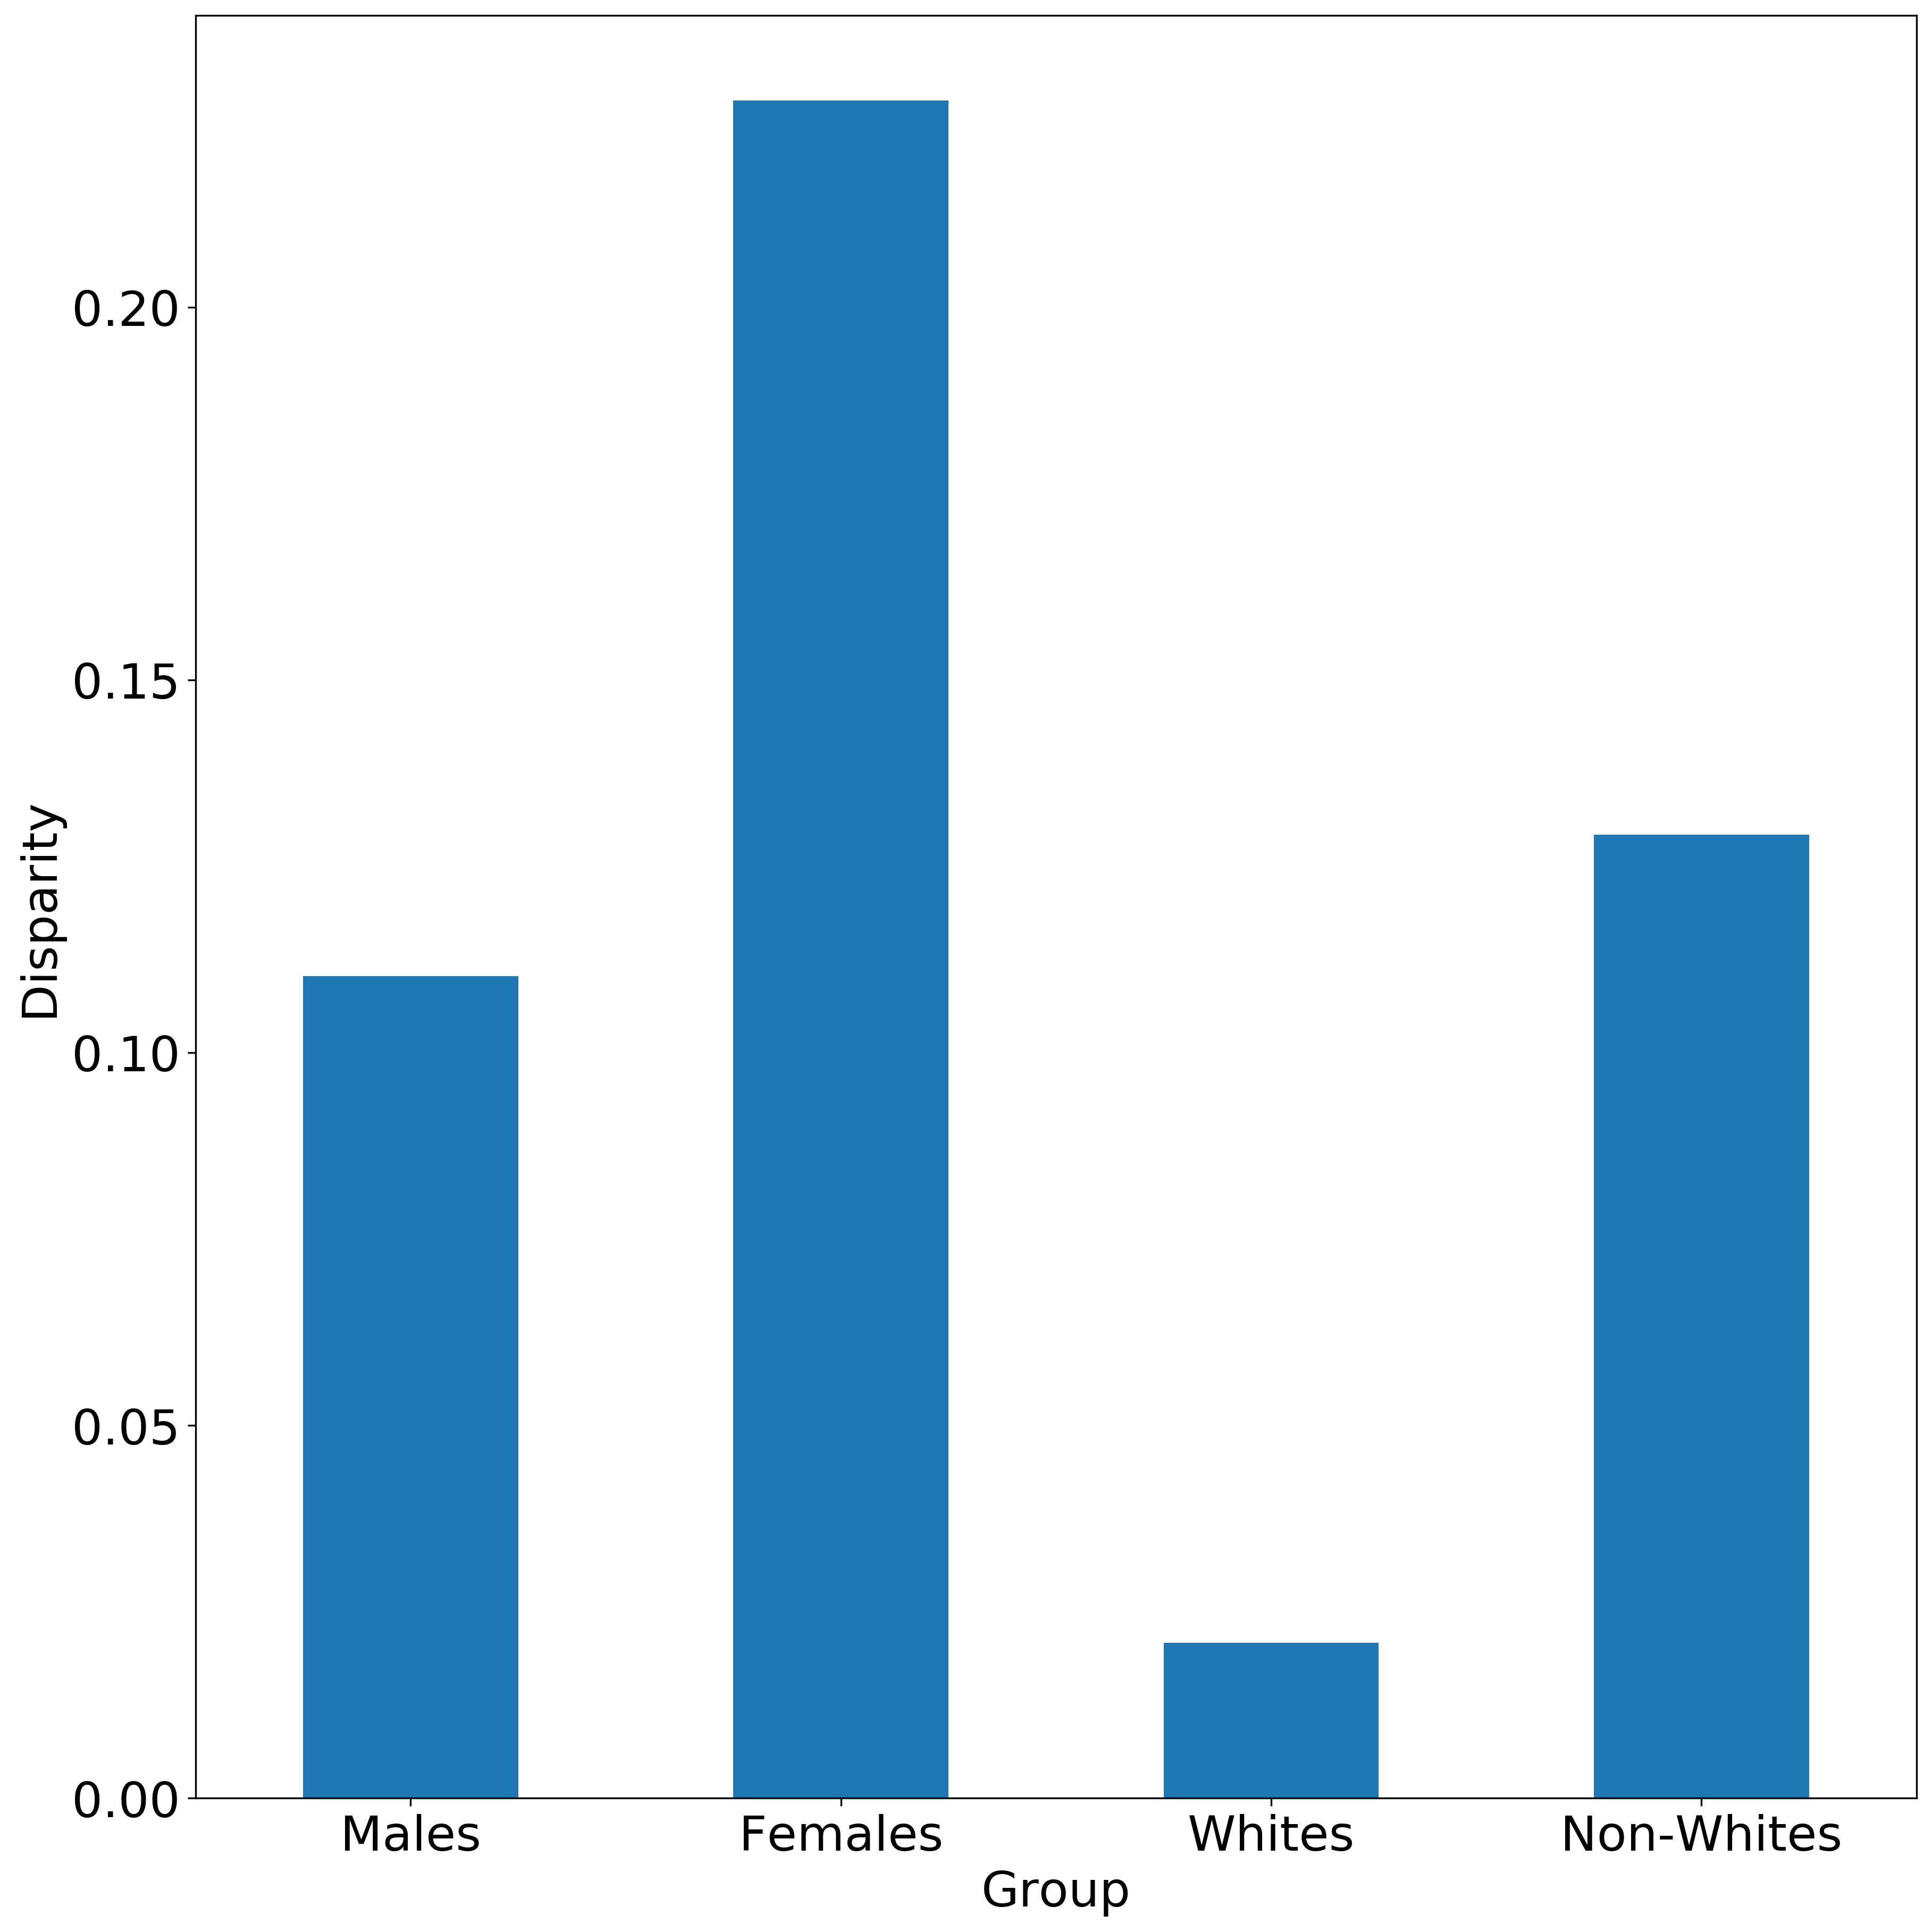

In [37]:
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1,1,figsize=(12,12), dpi=300, constrained_layout=True)

parity_df[parity_df['group']!= 'Dataset'].plot(x='group', y=['disparity'], kind='bar', ax=axes, rot=0)
axes.set_xlabel('Group')
axes.set_ylabel('Disparity')
axes.get_legend().remove()
plt.savefig('disparity_graph.png')

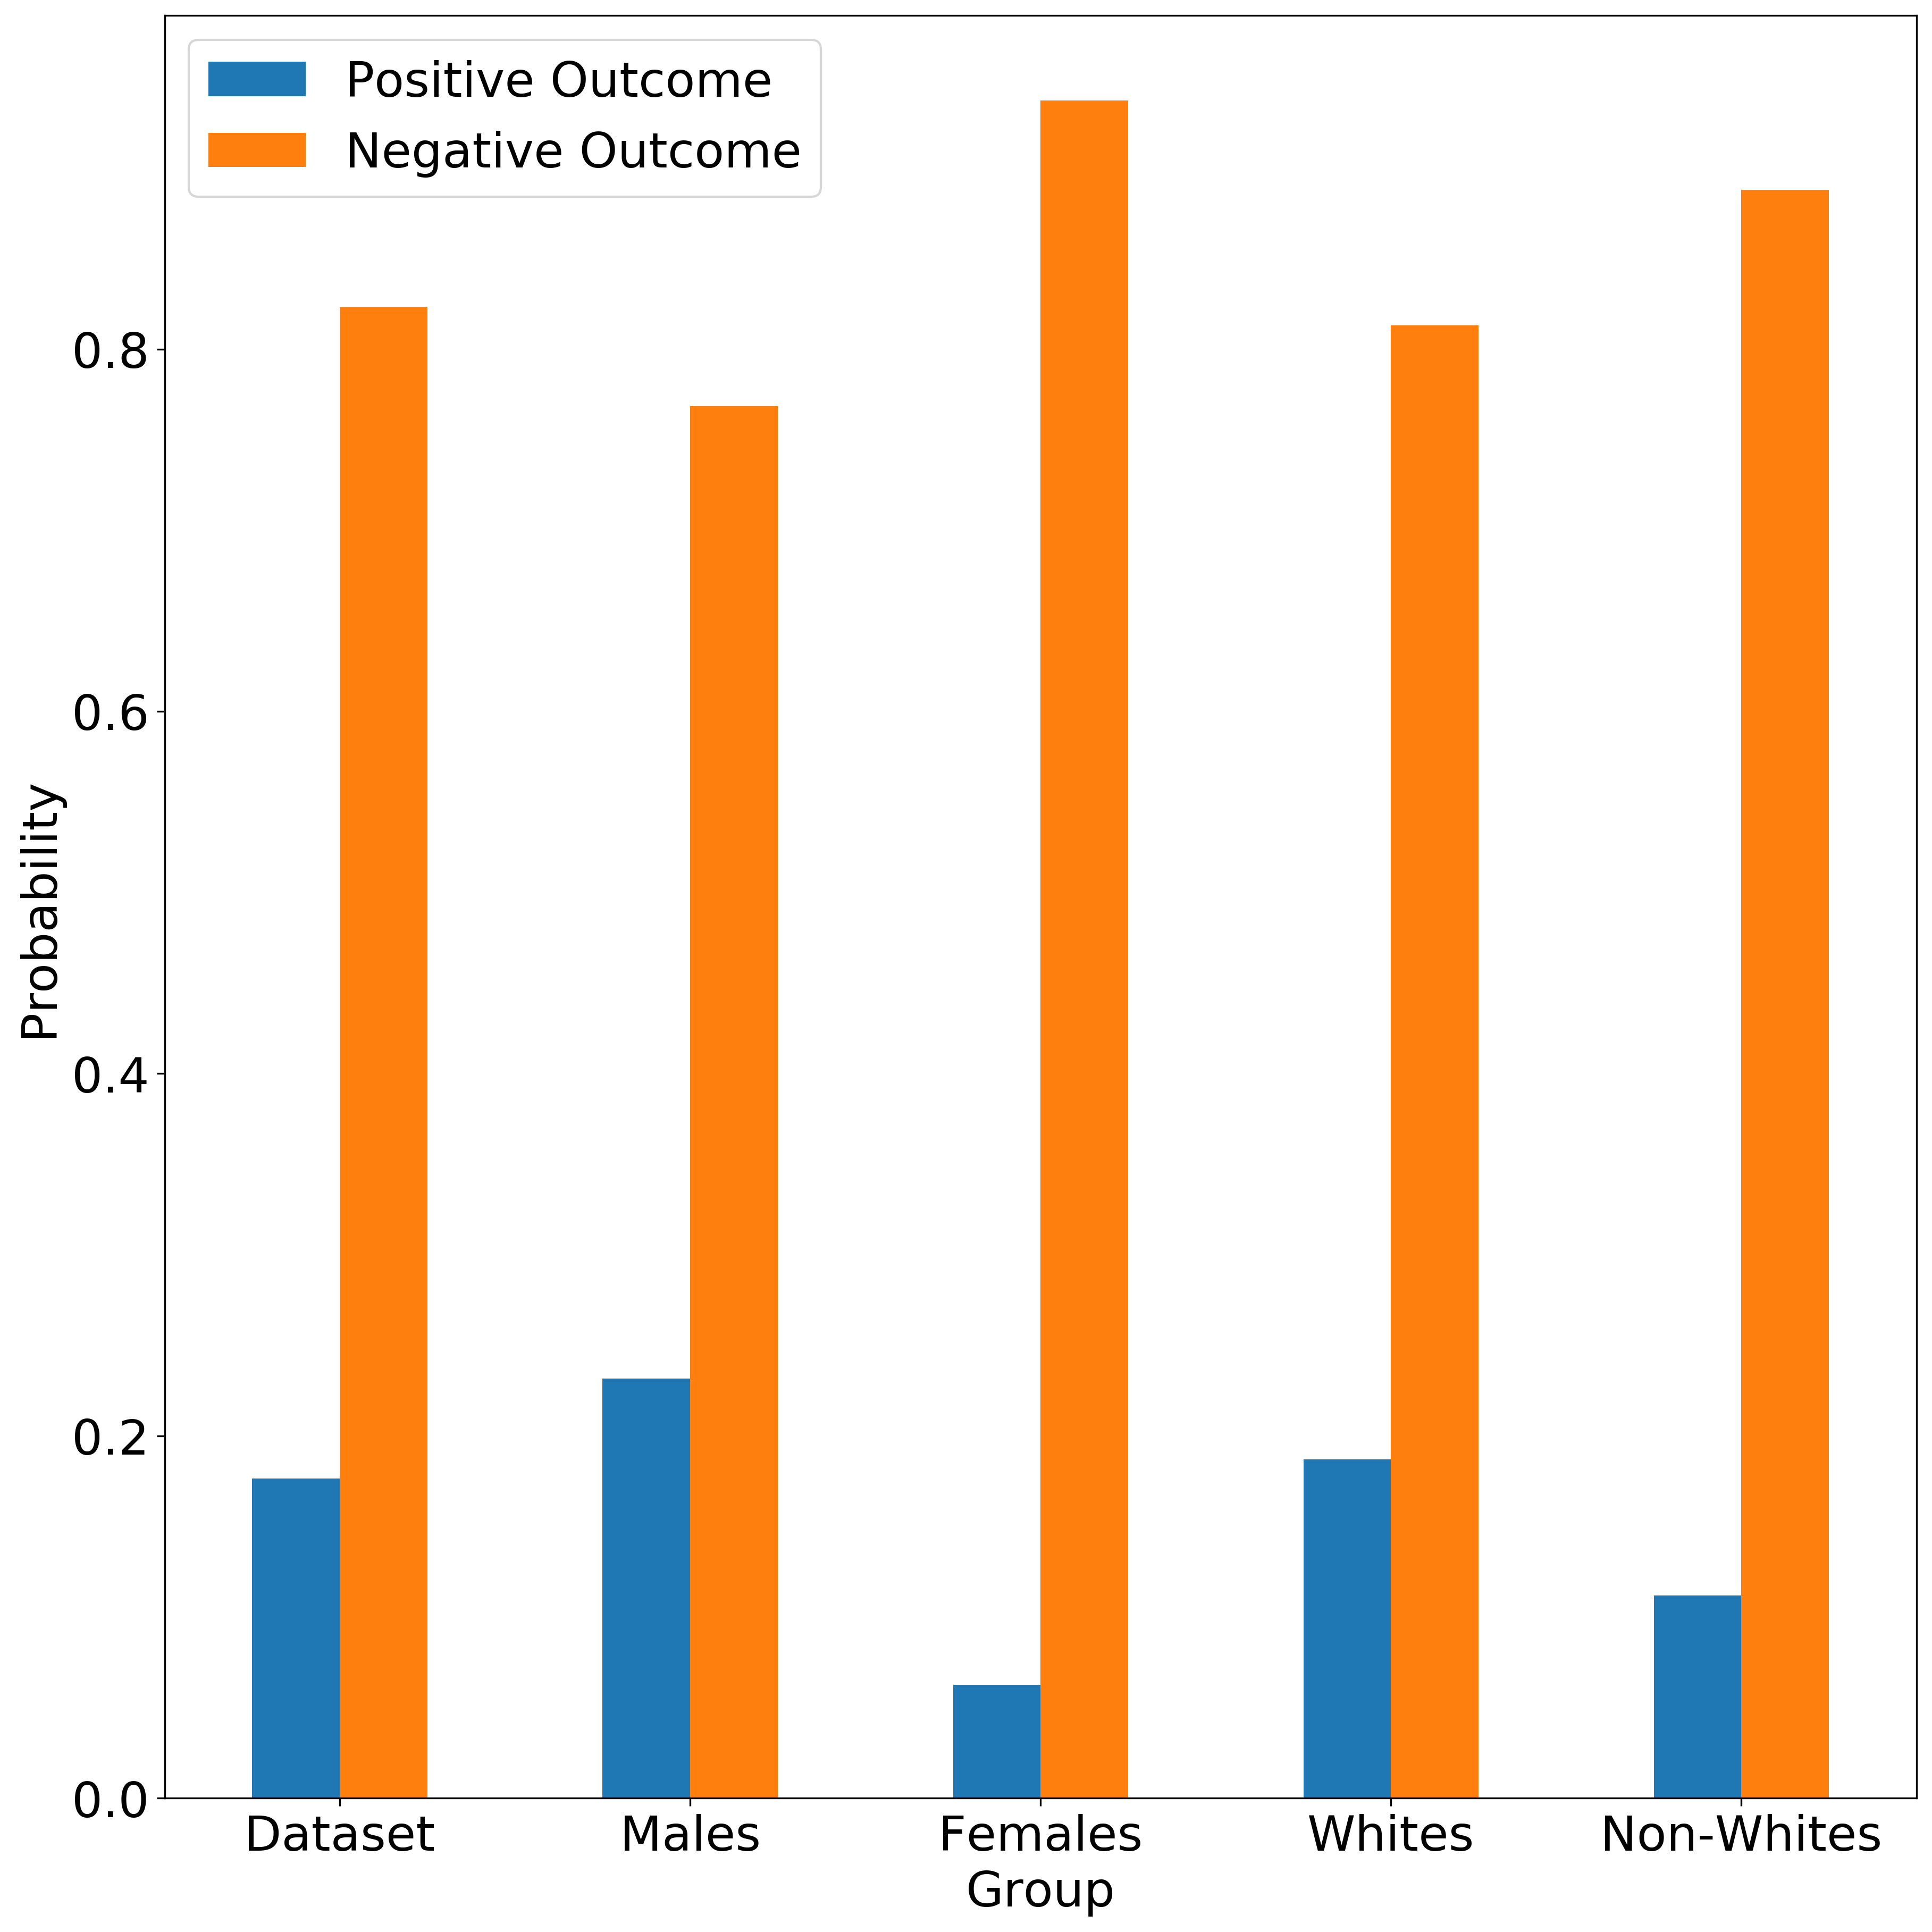

In [38]:


plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1,1,figsize=(12,12), dpi=300, constrained_layout=True)

parity_df.plot(x='group', y=['pos_parity','neg_parity'], kind='bar', ax=axes, rot=0)
axes.set_xlabel('Group')
axes.set_ylabel('Probability')
axes.legend(['Positive Outcome','Negative Outcome'])
plt.savefig('outcome_probability_graph.png')

In [ ]:
gender_df['FNR'] = 1 - gender_df['recall']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.barplot(gender_df.index, gender_df['FNR'], ax=axes)
plt.show()

In [ ]:
# why do women have more FN than TP? What factors do they share that make them more likely 
# to be predicted negative



#test[test['gender_Female']==1][test['income'] == '>50K'][test['native-country_United-States']==1][test['income'] != test['predicted_income']]
x = test[test['gender_Female']==1]
# 94% of the false negatives for women are for united states natives

x['fn'] = x[x['income'] == '>50K']['income'] != x[x['income'] == '>50K']['predicted_income']
x['fn'] = x['fn'].astype(float)
x[x['income'] == '>50K'].head()
# # convert one hot encodings to float values before applying correlation
# cols = x.select_dtypes(include=['uint8'])
# for col in cols:
#     x[col] = x[col].astype(float)

x_corr = x[x['income'] == '>50K'].drop(columns=['income', 'predicted_income']).corr()
# x.info()
# men have far more false positives. 23% inaccurate positive predictions to womens 18

In [ ]:
# weak correlation between relationship_Not-in-family and unmarried women
# married women less likely to be predicted to make less
for index, row in x_corr.sort_values(by=['fn'], ascending=False).iterrows():
    print(f'{index}: {row.fn}')

In [ ]:
test_race_df = test_data
test_race_df['income'] = test_label
test_race_df.head()

In [ ]:
# tune hyperparamters on training data
train_data, test_data, train_label, test_label = train_test_split(train.drop(columns=['income']), 
                                                                  train['income'], 
                                                                  test_size=0.2)

rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [10, 50, 100, 1000],
    'n_jobs': [-1, 1],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1e-1, 1, 10, 100],
    'criterion': ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(train.drop(columns=['income', 'dataset']), train['income'])

# select best performer
print (CV_rfc.best_params_)

# visualize each decision tree within the model, takes about 7Mb per tree

from sklearn.tree import export_graphviz
from sklearn import tree
import os
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=1600)
for i, tr in enumerate(model.estimators_):
    tree.plot_tree(tr,
                  feature_names=preprocess_dataset(train.drop(columns=['income'])).columns,
                  class_names=train['income'].unique(),
                  filled=True)
    plt.savefig(f'treeimg/tree{i}.png')